In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

### Load Data
Create a folder in the root folder named data and put the appropriate excel files in there
.gitignore will prevent it from the data being pushed to the git repo 

In [2]:
df = pd.read_excel('data\Report_21_050718_3.xls')

In [3]:
df_demographics = pd.read_excel('data/Proteomics-Subjects_Wcodes.xlsx')

In [4]:
df.columns = df.columns.str.replace(' ','_').str.lower()
df_demographics.columns = df_demographics.columns.str.replace(' ','_').str.lower()

In [5]:
'''
Converting long data to wide data
There are 12 subjects per group with 2 different dosages and total of 3 groups for 72 rows. 
We first identify the 72 columns, iterate through them and create one row per that item using pivot.
'''
out = pd.DataFrame()
for i in list(df.columns[((df.columns.str.endswith('_1') | df.columns.str.endswith('_2')))]):
    pat_info = i.split('_')
    df['pat_id'] = pat_info[0][1:]
    row = df.pivot(index='pat_id', columns='uniprot_id', values=i)
    row['dt_start'] = pat_info[1]
    row['dt_end'] = pat_info[2]
    row['dose']  = pat_info[3][:-2]
    row['group']  = pat_info[0][0]
    out = out.append(row)

### Join onto demographics

In [6]:
out.index = out.index.astype('int64')
df_demographics.set_index('id',inplace=True)
out = out.join(df_demographics)

### Normalizing Numeric Columns
We probably have to do this by demographics as well, but just keeping this here for framework

In [7]:
numeric_cols = out.loc[:,out.dtypes =='float64']
numeric_cols = (numeric_cols-numeric_cols.mean())/numeric_cols.std()
non_numeric_cols = out.loc[:,~(out.dtypes =='float64')]
out = pd.concat([numeric_cols,non_numeric_cols], axis=1)

### PCA, Exploratory Stuff

In [8]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(numeric_cols)  
print(np.sum(pca.explained_variance_ratio_))

0.6695078625386939


In [9]:
print(pca.singular_values_)  

[222.17423512  66.33822516]


In [10]:
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [11]:
finalDf = pd.concat([principalDf, out['group'].reset_index(drop=True)], axis = 1)

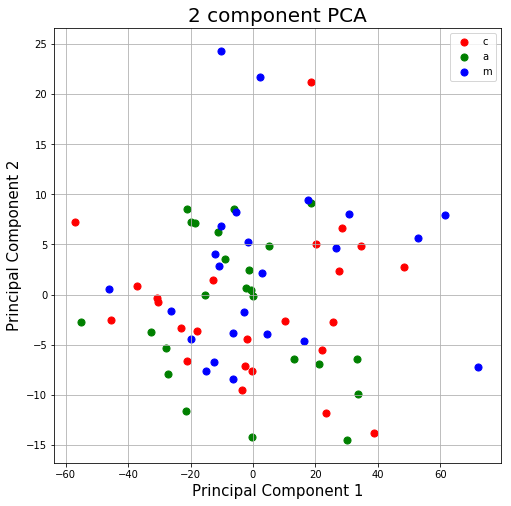

In [12]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['c','a','m']
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['group'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

## T-SNE

In [14]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2).fit_transform(numeric_cols)

In [18]:
finalDf['tsne1'] = tsne[:,0]
finalDf['tsne2'] = tsne[:,1]

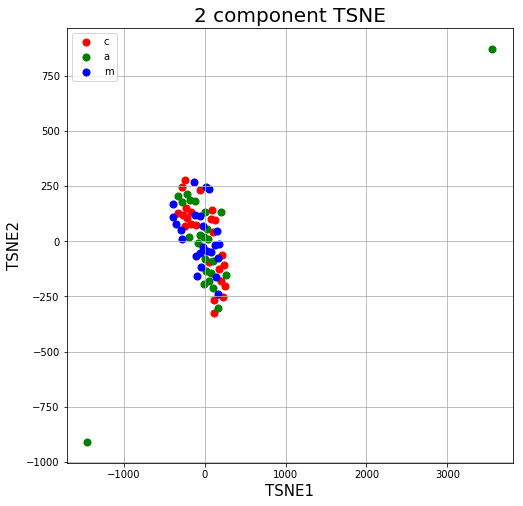

In [21]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('TSNE1', fontsize = 15)
ax.set_ylabel('TSNE2', fontsize = 15)
ax.set_title('2 component TSNE', fontsize = 20)
targets = ['c','a','m']
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['group'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'tsne1']
               , finalDf.loc[indicesToKeep, 'tsne2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

# Pair visualization

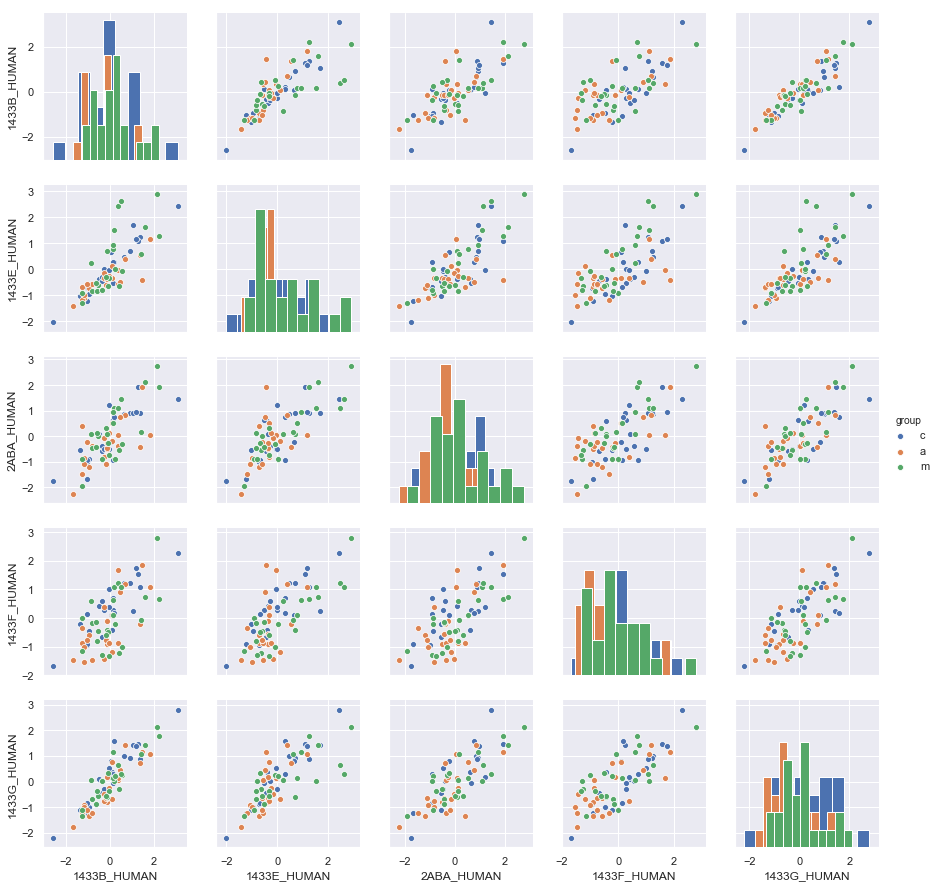

In [39]:
import seaborn as sns
numeric_cols['group'] = out['group']
sns.set(rc={'figure.figsize':(22.7,16.27)})
sns.pairplot(numeric_cols[['1433B_HUMAN','1433E_HUMAN','group','2ABA_HUMAN','1433F_HUMAN','1433G_HUMAN']].dropna(), hue = 'group',diag_kind = 'hist')

# Covariance Matrix

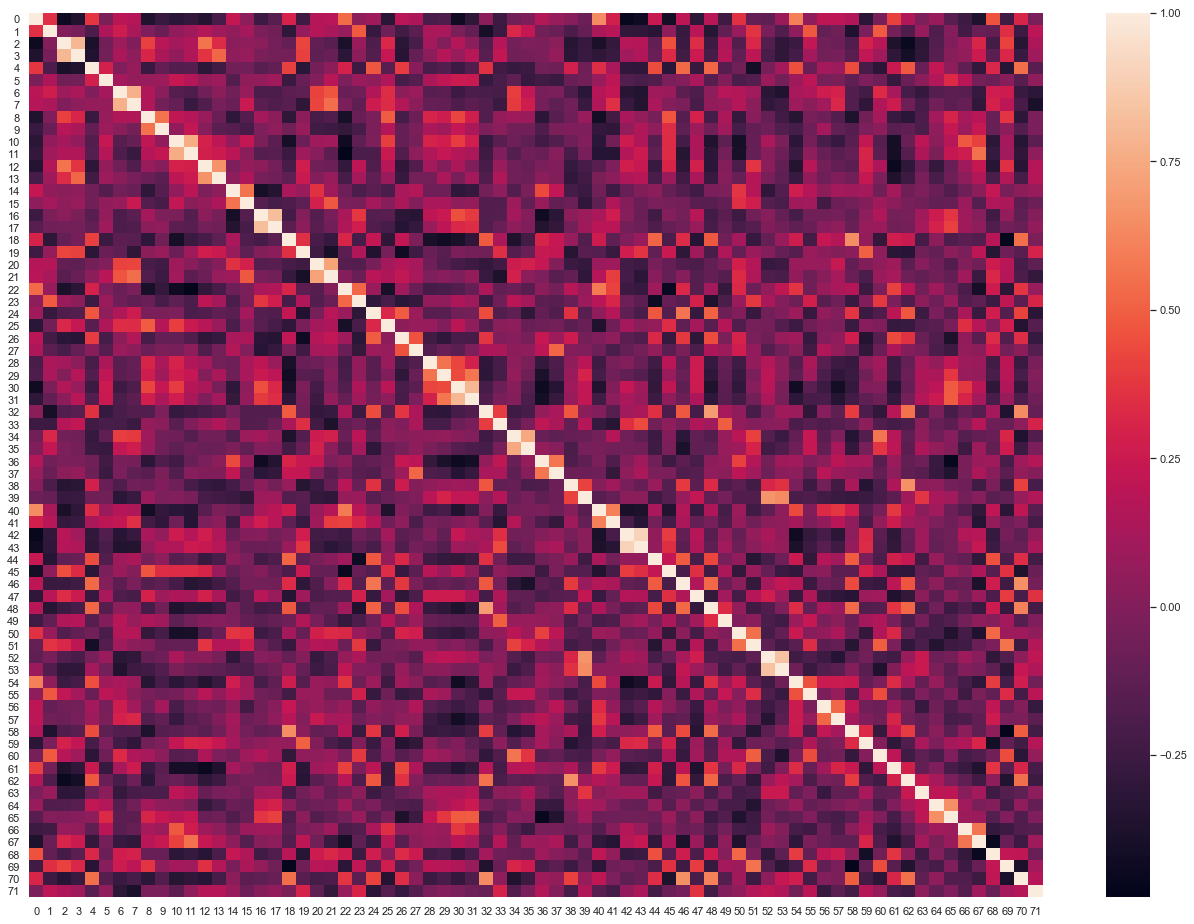

In [44]:
sns.heatmap(np.corrcoef(numeric_cols.drop(['group'], axis=1)))

# Feature Selection

In [234]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel
X, y = numeric_cols.drop(['group'], axis=1), numeric_cols['group']

clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(X, y)
clf.feature_importances_  
model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X)
X_new.shape               


(72, 443)

In [235]:
from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.33)

lsvc = SVC(C=0.01).fit(X_new, y)
lsvc.fit(X_train,y_train).score(X_test,y_test)

C:\Users\Mert Ketenci\Anaconda3\envs\dlenv\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Mert Ketenci\Anaconda3\envs\dlenv\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.25